<a href="https://colab.research.google.com/github/j-buss/wi-dpi-analysis/blob/development/eda/5.0_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Salary and Education in Wisconsin - 5.0 Analysis

### Prep

### Import Libraries

In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import bigquery

In [0]:
%matplotlib inline
plt.style.use('bmh')



### Functions



### Processing

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [0]:
project_id='wi-dpi-010'
landing_dataset_name='landing'
refined_dataset_name='refined'
gold_dataset_name='gold'

In [0]:
bq_client = bigquery.Client(project=project_id)

# Analysis

## Explore Salaries

In [0]:
sql='''
  SELECT
    *
  FROM
    {}.{}
'''.format('refined','2015_all_staff_report')

In [7]:
df = pd.read_gbq(sql, project_id=project_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173824 entries, 0 to 173823
Data columns (total 39 columns):
id_nbr                     173824 non-null int64
first_name                 173824 non-null object
last_name                  173824 non-null object
file_number                138678 non-null object
gender                     173824 non-null object
race_ethnicity             173824 non-null object
birth_year                 173824 non-null int64
high_degree_cd             104466 non-null object
high_degree_desc           104466 non-null object
year_session               173824 non-null object
contract_days              173824 non-null int64
local_exp                  103834 non-null float64
total_exp                  103834 non-null float64
salary                     173824 non-null float64
benefits                   173824 non-null float64
staff_category_cd          173823 non-null object
staff_category_desc        173823 non-null object
school_cd                  173824 non-

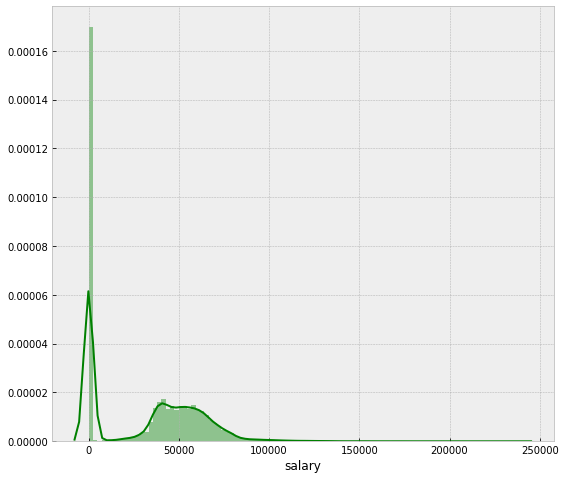

In [9]:
plt.figure(figsize=(9, 8))
sns.distplot(df['salary'], color='g', bins=100, hist_kws={'alpha': 0.4})

### Why are there $0 salaries?

There are 69,990 records that show a $0 salary.

ADD A CHART WHICH SHOWS THE RECORDS WITH, WITHOUT

In [0]:
records_w_o_salary = df['salary'][df['salary']==0].count()
records_w_salary = df['salary'][df['salary']!=0].count()
total_records = df['salary'].count()

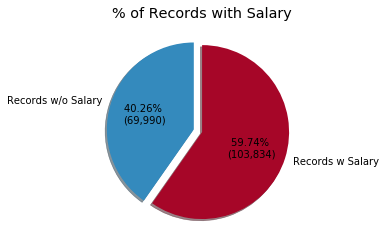

In [26]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Records w/o Salary', 'Records w Salary']
values = [records_w_o_salary, records_w_salary]
explode = (0.1, 0)

def make_autopct(values):
  def my_autopct(pct):
    total = sum(values)
    val = int(round(pct*total/100.0))
    return '{p:.2f}% \n({v:,d})'.format(p=pct,v=val)
  return my_autopct

#fig1, ax1 = plt.subplots()
#ax1.pie(sizes, explode=explode, labels=labels, autopct=make_autopct(values),
#        shadow=True, startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('% of Records with Salary')
plt.pie(values, explode=explode, labels=labels, autopct=make_autopct(values),
       shadow=True, startangle=90)
plt.show()

In [0]:
#Same analysis but with SQL to verify
sql_salary_summary ='''
  SELECT
    sum(a.no_salary) as count_no_salary,
    sum(a.has_salary) as count_has_salary,
    count(*) as count_total_record
  FROM
    (SELECT
      CASE WHEN (salary = 0 OR salary is null) THEN 1
      ELSE 0
      END AS no_salary,
      CASE WHEN (salary <> 0 AND salary is not null) THEN 1
      ELSE 0
      END as has_salary
    FROM
      `wi-dpi-010.refined.2015_all_staff_report`) a
'''

Examining the job categories of roles that either do or do not have Salary information:

In [0]:
sql_role_cat_w_salary = '''
SELECT
  A.staff_category_desc,
  A.position_description,
  A.position_type_cd,
  sum(has_salary) Salary,
  sum(has_contract) Contract,
  sum(no_salary) No_Salary,
  sum(no_contract) No_Contract
FROM
  (SELECT
    staff_category_desc,
    position_description,
    position_type_cd,
    CASE WHEN (salary = 0 OR salary is null) THEN 1
    ELSE 0
    END AS no_salary,
    CASE WHEN (salary <> 0 AND salary is not null) THEN 1
    ELSE 0
    END as has_salary,
    CASE WHEN (contract_days = 0 OR contract_days is null) THEN 1
    ELSE 0
    END AS no_contract,
    CASE WHEN (contract_days <> 0 AND contract_days is not null) THEN 1
    ELSE 0
    END as has_contract
  FROM
    {}.{}) A
GROUP BY
  A.staff_category_desc,
  A.position_description,
  A.position_type_cd
'''.format('refined','2015_all_staff_report')

In [66]:
df_role_cat_w_salary = pd.read_gbq(sql_role_cat_w_salary, project_id=project_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


In [73]:
df_role_cat_w_salary[['A_staff_category_desc','Salary','No_Salary']]\
  .groupby('A_staff_category_desc').sum().sort_values(
  by=['Salary','No_Salary'],
  ascending=False)

,Salary,No_Salary
A_staff_category_desc,,
Professional-Regular Education,81013,650
Professional-Special Education,22821,327
Support-Regular Education,0,42725
Short-Term Substitute/Extra Curricular Activities,0,14196
Support-Special Education,0,12091


Adding in some inforamtion about contracts we see that the two are corelated:

In [74]:
df_role_cat_w_salary\
  .groupby('A_staff_category_desc').sum().sort_values(
  by=['Salary','No_Salary'],
  ascending=False)

,Salary,Contract,No_Salary,No_Contract
A_staff_category_desc,,,,
Professional-Regular Education,81013,81013,650,650
Professional-Special Education,22821,22821,327,327
Support-Regular Education,0,0,42725,42725
Short-Term Substitute/Extra Curricular Activities,0,0,14196,14196
Support-Special Education,0,0,12091,12091


Generally speaking the roles either display Salary information or not. There do seem to be a few exceptions to this rule. Analyzing the data in a bit more detail we filter on a few positions which seem to have some split. The majority being Salary/Contract, but a small percentage being No-Salary/No-Contract.

In [78]:
df_role_cat_w_salary[['A_staff_category_desc','A_position_description','Salary','Contract','No_Salary','No_Contract']]\
  [(df_role_cat_w_salary['A_position_description']=='Teacher') | 
   (df_role_cat_w_salary['A_position_description']=='School Physical Therapy') | 
   (df_role_cat_w_salary['A_position_description']=='School Occupational Therapy') |
   (df_role_cat_w_salary['A_position_description']=='Speech/Language Pathologist')]\
  .sort_values(by=['Salary','No_Salary'],ascending=False)

,A_staff_category_desc,A_position_description,Salary,Contract,No_Salary,No_Contract
24,Professional-Regular Education,Teacher,64325,64325,572,572
25,Professional-Special Education,Teacher,11248,11248,108,108
38,Professional-Special Education,Speech/Language Pathologist,2378,2378,46,46
30,Professional-Special Education,School Occupational Therapy,894,894,56,56
28,Professional-Special Education,School Physical Therapy,505,505,53,53


SHOULD WE ADD AN AVERAGE SALARY BY POSITION

Summary: Roles tend to have Salary information or not.

### How many people have a salary?

The previous analysis started by examining salary data. What we found is that there are a number records in the data set that do not show salary data as these roles do not have a contract. We filtered the data out to find some information about the roles that were under contract and therefore had a salary. 

For this step, as we want to go deeper into the Salary data we still need to answer the question about people.

How many people in the dataset?

In [80]:
df.groupby(['id_nbr']).count()

,first_name,last_name,file_number,gender,race_ethnicity,birth_year,high_degree_cd,high_degree_desc,year_session,contract_days,local_exp,total_exp,salary,benefits,staff_category_cd,staff_category_desc,school_cd,position_cd,position_description,position_type_cd,position_type_desc,assignment_area_cd,assignment_area_desc,low_grade_cd,low_grade_desc,high_grade_cd,high_grade_desc,assignment_fte,school_name,grade_level_cd,grade_level_desc,cesa_number,cnty_name,school_mailing_address1,school_mailing_address2,mail_city,mail_st,mail_zip_cd
id_nbr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
279220,1,1,0,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
279221,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
279222,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
279223,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
279224,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
279225,1,1,0,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1
279226,1,1,0,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
279227,1,1,0,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1
279228,1,1,0,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1


Let's filter that list by the max salary:

In [0]:
df[df['salary']!=0].groupby(['id_nbr','first_name','last_name'])['salary'].max().count()

72760

In [0]:
#with SQL
SELECT
  id_nbr,
  first_name,
  last_name,
  max(salary)
FROM
  `wi-dpi-010.refined.2015_all_staff_report`
GROUP BY 1, 2, 3
HAVING max(salary) > 0

This data has been saved into the gold.party_w_salary table.

In [0]:
sql='''
  SELECT
    *
  FROM
    {}.{}
'''.format('gold','party_w_salary')

In [0]:
df_party_w_salary = pd.read_gbq(sql, project_id=project_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


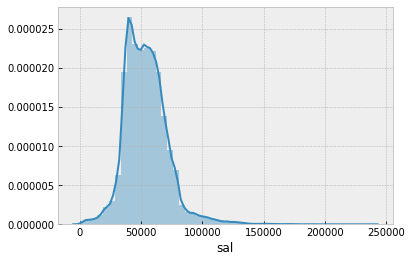

In [0]:
sns.distplot(df_party_w_salary['sal'],norm_hist=True)

### What are the factors that affect salary?

In [0]:
#Characteristics of the individual: Age, Experience, Gender, RaceEthnicity,
#Characteristics of their roles: FTE, Number of Roles, Teacher/Administrator, Subject, School, Cesa
#Create Linear Regression to predict the Salary of an individual